<a href="https://colab.research.google.com/github/pankajti/wqu/blob/main/DL/Gwp3_grp3941.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyts
from IPython.display import clear_output
clear_output()

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
import pandas as pd
import gc
import os
import random
import copy
import statsmodels
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import plotly.graph_objects as go
import sklearn
from pyts.image import GramianAngularField
import tensorflow as tf
from keras.callbacks import EarlyStopping


In [3]:
ticker = 'BTC-USD'

In [4]:
data= yf.download(ticker)

[*********************100%%**********************]  1 of 1 completed


In [5]:
close = data.Close[-2000:]

<Axes: xlabel='Date'>

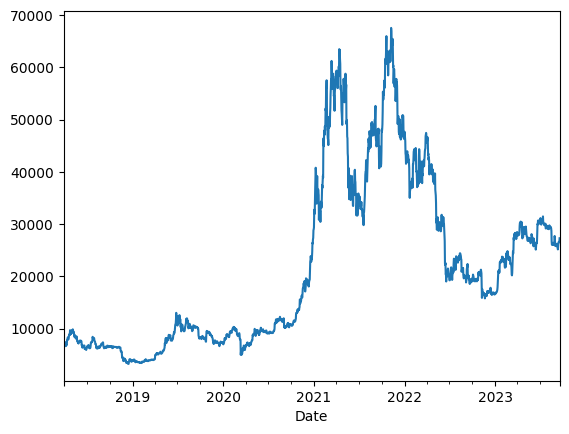

In [6]:
close.plot()

In [7]:
ret = close.pct_change()

<Axes: xlabel='Date'>

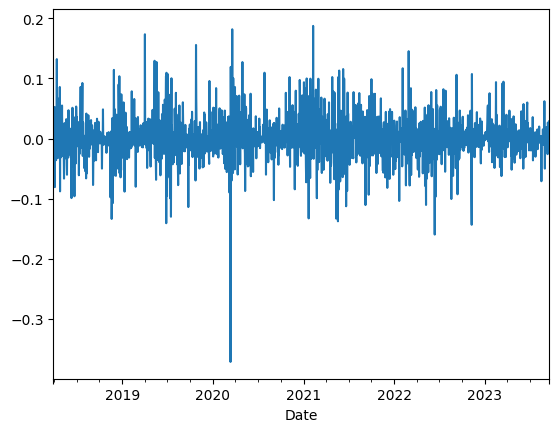

In [8]:
ret.plot()

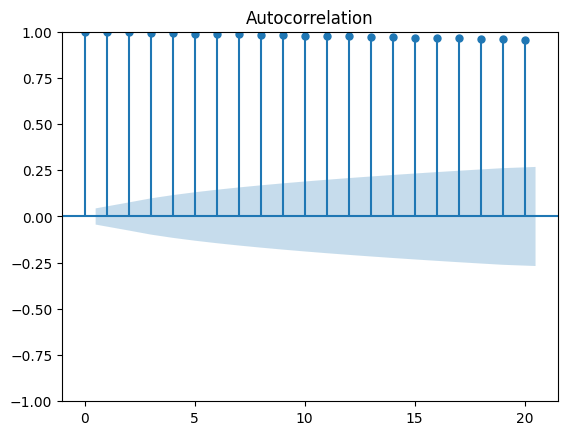

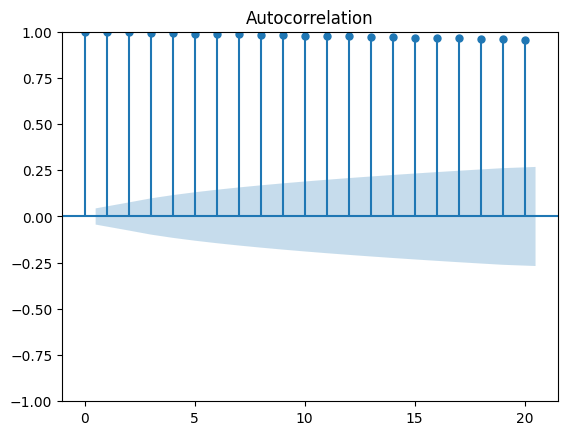

In [9]:
plot_acf(close, lags =20)


In [10]:
adftest=adfuller(close)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -1.495029
ADF p-value: 0.535969


In [11]:
def get_mlp_data(time_series):
  ts_data = pd.DataFrame()
  lags = 30
  ts_data['t']=time_series
  for l in range(1,lags+1) :
    ts_data[f't_{l}'] = time_series.shift(l)

  X= ts_data.iloc[:,1:]
  y=ts_data['t_1']>ts_data[f't_{lags}']
  X=X[lags:]
  y=y[lags:]
  return X,y

In [12]:
def get_mlp_model():
  model = Sequential()
  model.add(Dense(100, activation ='relu'))
  model.add(Dense(1,activation = 'linear', name='output'))
  return model

# model = get_mlp_model()
# model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= ['accuracy'] )
# model.fit(X,y, batch_size =8, epochs =10)

In [13]:
def get_transofromed_images_labels(time_series ,window_size = 30):
  X_data = []
  for i in range(window_size, time_series.shape[0]):
      X_data.append(time_series[i - window_size : i])
  X_data = np.array(X_data)
  transformer = GramianAngularField()
  X_data_new = transformer.transform(X_data)
  y_data = []
  for i in range(0, time_series.shape[0] - window_size):
      y_data.append(time_series[i] < time_series[i + window_size])
  y_data = np.array(y_data)
  return X_data, X_data_new , y_data,

In [14]:
orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(close)

NameError: ignored

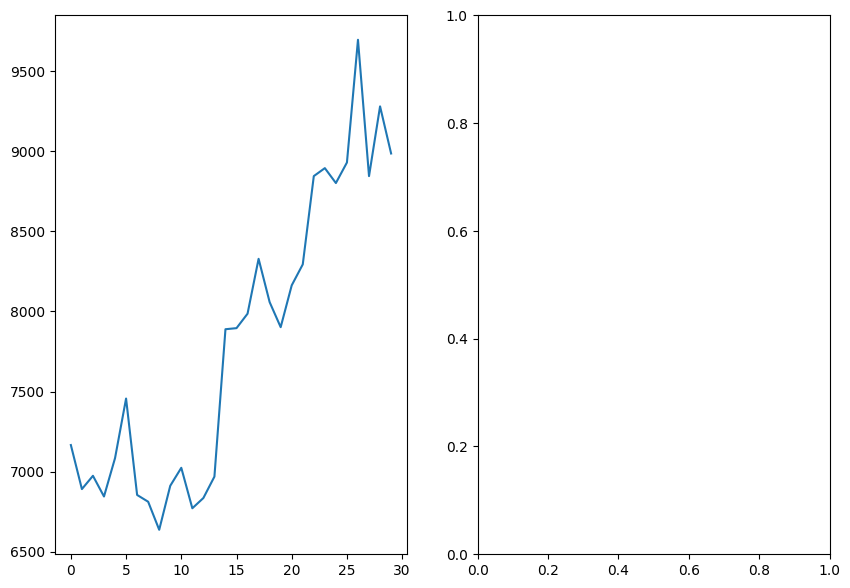

In [15]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(orig_data[0, :])
ax[1].imshow(transformed_imgs[0], cmap="rainbow",label =y[0])
plt.legend()

In [16]:
def get_cnn_model():
  model = Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  return model

In [17]:
# model = get_cnn_model()
# orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(close)
# model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

# history = model.fit(transformed_imgs, y_labels, epochs=10,  )

In [18]:
def get_lstm_model( ip_size,  n_features=1):
  SEED = 1234
  units_lstm = 50
  n_dropout = 0.2
  act_fun = "relu"
  model = tf.keras.models.Sequential( )
  model.add(tf.keras.layers.LSTM(units=units_lstm,return_sequences=True,activation="tanh",input_shape=(ip_size, n_features),))
  model.add(tf.keras.layers.LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))


  model.add(tf.keras.layers.LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))


  model.add(tf.keras.layers.LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))

  model.add(tf.keras.layers.Dense(units=20, activation=act_fun))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))

  model.add(tf.keras.layers.Dense(units=10, activation=act_fun))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))

  model.add(tf.keras.layers.Dense(1))
  return model

In [19]:
def run_model(model, X_train, y_train):
  hp_lr = 1e-4
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
  )
  es = EarlyStopping(
      monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
  )
  # fit the models
  model.fit(
      X_train,
      y_train,
      validation_split=0.2,
      epochs=50,
      batch_size=64,
      callbacks=[es],verbose=0
  )

In [20]:
close

Date
2018-03-29     7165.700195
2018-03-30     6890.520020
2018-03-31     6973.529785
2018-04-01     6844.229980
2018-04-02     7083.799805
                  ...     
2023-09-14    26539.673828
2023-09-15    26608.693359
2023-09-16    26568.281250
2023-09-17    26534.187500
2023-09-18    27304.761719
Name: Close, Length: 2000, dtype: float64

In [21]:
#ret.iloc[i + (n_train) : i + n_train + n_test].values

In [24]:
#X, y = df.iloc[:, 2:-1], df.iloc[:, -1]
X, y = get_mlp_data(close)

X= X[-2000:]
y= y[-2000:]
hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"
print(X.shape, y.shape)
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = close.index[i + (n_train) : i + n_train + n_test].values
    Ret_vector = ret.iloc[i + (n_train) : i + n_train + n_test].values
    print("ite ",i / n_test,X_train.shape,y_train.shape,X_test.shape,y_test.shape,)
    model = get_mlp_model()
    run_model(model, X_train, y_train)
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)


(1970, 30) (1970,)
ite  0.0 (500, 30) (500,) (100, 30) (100,)
ite  1.0 (500, 30) (500,) (100, 30) (100,)
ite  2.0 (500, 30) (500,) (100, 30) (100,)
ite  3.0 (500, 30) (500,) (100, 30) (100,)
ite  4.0 (500, 30) (500,) (100, 30) (100,)
ite  5.0 (500, 30) (500,) (100, 30) (100,)
Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
ite  6.0 (500, 30) (500,) (100, 30) (100,)
ite  7.0 (500, 30) (500,) (100, 30) (100,)
ite  8.0 (500, 30) (500,) (100, 30) (100,)
ite  9.0 (500, 30) (500,) (100, 30) (100,)
ite  10.0 (500, 30) (500,) (100, 30) (100,)
ite  11.0 (500, 30) (500,) (100, 30) (100,)
ite  12.0 (500, 30) (500,) (100, 30) (100,)
ite  13.0 (500, 30) (500,) (100, 30) (100,)
ite  14.0 (500, 30) (500,) (70, 30) (70,)


ValueError: ignored

In [ ]:

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

In [ ]:
ret_backtest.shape

In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res.tail()

In [ ]:
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

In [ ]:
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")